# Importation du dataset de kaggle
Il faut importer d'abord le fichier kaggle.json

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kazanova/sentiment140

 98% 79.0M/80.9M [00:01<00:00, 86.6MB/s]
100% 80.9M/80.9M [00:01<00:00, 73.4MB/s]


In [ ]:
!unzip sentiment140

Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


# **Importation des librairies et données nécessaires**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import tensorflow as tf  # Library for building and training neural networks
import matplotlib.pyplot as plt  # Library for creating visualizations
import nltk  # Natural Language Toolkit
nltk.download('stopwords')  # Downloading stopwords data
nltk.download('punkt')
from nltk.corpus import stopwords  # Importing stopwords from NLTK corpus
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split  # Library for splitting data into train and test sets
import re  # Library for regular expressions


data = pd.read_csv('./training.1600000.processed.noemoticon.csv',
                 encoding = 'latin',header=None)
data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# **Preprocessing**

In [ ]:
data.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
data = data.drop(['id', 'date', 'query', 'user_id'], axis=1)

#Changer les valeurs de 0 et 1 à négative et positive
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def changeLabel(label):
  return lab_to_sentiment[label]

data.sentiment = data.sentiment.apply(lambda x: changeLabel(x))
data.head()


,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


In [ ]:
data.sentiment.value_counts()

Negative    800000
Positive    800000
Name: sentiment, dtype: int64

Text(0.5, 1.0, 'Sentiment Data Distribution')

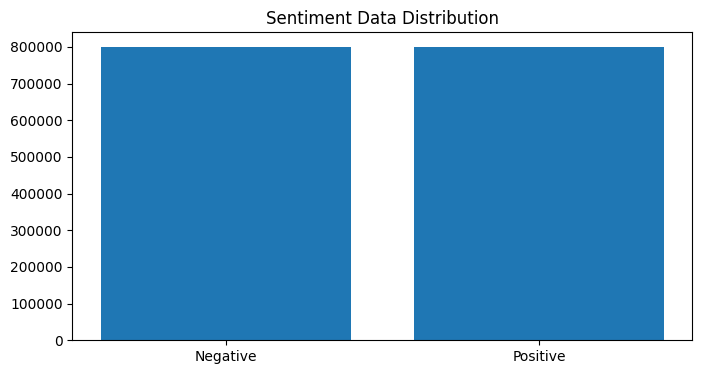

In [ ]:
#Vérifier si nos classes sont homogènes
val_count = data.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

*On remarque qu'on a le même nombre d'entrées dans les deux classes, pas la peine de balancer entre les deux*

In [ ]:
# Function to clean specific tokens
def cleaned(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token == 'amp' or token == 'quot' or token == 'lt' or token == 'gt' or token == '½25':
        return ''
    return token


In [ ]:
stop_words = stopwords.words('english')
from nltk.tokenize import word_tokenize
stemmer = SnowballStemmer('english')
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# Function to preprocess text
def preprocess(text, stem=False):
    # Cleaning text using regex
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    # Tokenizing text
    tokens = word_tokenize(text)
    # List to store preprocessed tokens
    preprocessed_tokens = []

    for token in tokens:
        if (token.lower() not in stop_words) or (token.lower() in ['not', 'no']):
            # Stemming the token if stem is true
            if stem :
                token = stemmer.stem(token)
            # Cleaning token using the cleaned function
            token = cleaned(token)
            # Appending preprocessed token to list
            if token:
                preprocessed_tokens.append(token)

    # Joining tokens back into a string
    return ' '.join(preprocessed_tokens)

In [ ]:
# Applying preprocessing to the 'text' column of the DataFrame 'data'
from time import time
start_time = time()
data.text = data.text.apply(lambda x: preprocess(x))
print('CPU Time:', time() - start_time)
data.head()

CPU Time: 250.26411843299866


,sentiment,text
0,Negative,awww bummer shoulda got david carr third day
1,Negative,upset update facebook texting might cry result...
2,Negative,dived many times ball managed save 50 rest go ...
3,Negative,whole body feels itchy like fire
4,Negative,no not behaving mad see


Nos données sont maintenant netoyées et prêtes à être utilisée

# Visualisation des mots à travers des nuages de mots

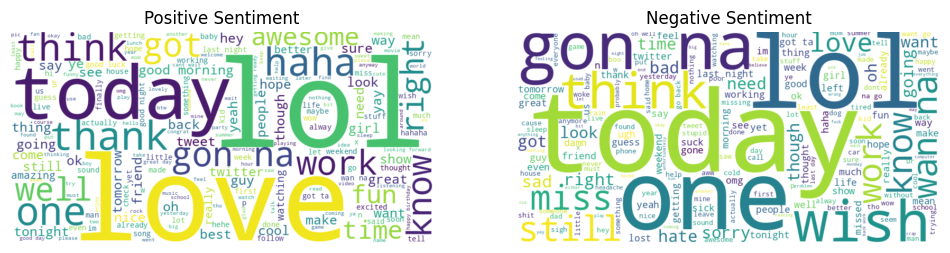

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Separate data into positive and negative sentiments
positive_data = data[data['sentiment'] == 'Positive']
negative_data = data[data['sentiment'] == 'Negative']

# Drop NaN values from text column
positive_data = positive_data.dropna(subset=['text'])
negative_data = negative_data.dropna(subset=['text'])

# Join all tokens for each sentiment into a single string
positive_text = ' '.join(str(token) for token in positive_data['text'].explode())
negative_text = ' '.join(str(token) for token in negative_data['text'].explode())

# Generate word clouds for positive and negative sentiments
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Plot word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Sentiment')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Sentiment')
plt.axis('off')

plt.show()

# Diviser le dataset en Train and Test Data

In [ ]:
TRAIN_SIZE = 0.8
train_data, test_data = train_test_split(data, test_size=1-TRAIN_SIZE,random_state=42)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


In [ ]:
#test
train_data.head(10)

,sentiment,text
1374558,Positive,ya like palm pre touchstone charger readynow y...
1389115,Positive,felt earthquake afternoon seems epicenter
1137831,Positive,ruffles shirts like likey
790714,Negative,pretty bad night crappy morning fml buttface d...
1117911,Positive,yeah clear view
1077663,Positive,one time follow fam ff georgeann13 nakithebeat...
1253991,Positive,you rock thanks added next robcrotch tm video
1535242,Positive,yes please met fiancee ian party day btw sweet...
1396460,Positive,gawd finished whole bowl even posted previous ...
1178954,Positive,awesome game short finish craving god war action


# Encodage des labels

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Initializes a LabelEncoder object, used to encode categorical labels into numerical labels
encoder = LabelEncoder()

# Fits the encoder to the sentiment labels in the training data
encoder.fit(train_data.sentiment.to_list())

# Transforms the sentiment labels in the training data into numerical labels using the fitted encoder
y_train = encoder.transform(train_data.sentiment.to_list())

# Transforms the sentiment labels in the test data into numerical labels using the same encoder fitted on the training data
y_test = encoder.transform(test_data.sentiment.to_list())

# Reshapes the y_train array to have a single column
y_train = y_train.reshape(-1, 1)

# Reshapes the y_test array to have a single column
y_test = y_test.reshape(-1, 1)

# Prints the shape of the y_train array to verify its dimensions
print("y_train shape:", y_train.shape)

# Prints the shape of the y_test array to verify its dimensions
print("y_test shape:", y_test.shape)

print(y_test)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [0]]


# Tokenization et définition du vocabulaire des données d'entrainement

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 290401


In [ ]:
from keras.preprocessing.sequence import pad_sequences
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Vocabulary Size :", vocab_size)
print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)
print(x_train)

Vocabulary Size : 290401
Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)
[[     0      0      0 ...    710    119  24574]
 [     0      0      0 ...    451    378  32431]
 [     0      0      0 ...   2040      5   5475]
 ...
 [     0      0      0 ...    660   4234 290398]
 [     0      0      0 ...     13    476    953]
 [     0      0      0 ...     11    501    268]]


# Embedding des mots

On utilise GloVe, le modèle de Stanford AI

In [ ]:
#Télecharement des vecteurs d'embedding GloVe pré-entrainés
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip


--2024-03-28 19:46:37--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-03-28 19:46:37--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-03-28 19:46:37--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
GLOVE_EMB = './glove.6B.300d.txt'  #chemin des vecteurs téléchargés
EMBEDDING_DIM = 300 #dimension des embeddings

In [ ]:
#Définition des paramètres d'entraînement pour les modèle
LR = 1e-3 #Taux d'apprentissage
BATCH_SIZE = 1024
EPOCHS = 10 #Nombre d'epochs pour entraînement


In [ ]:
embeddings_index = {} #initialisation du dictionnaire clé : mot ; valeurs : vecteur correspondant
f = open(GLOVE_EMB)
for line in f: #parcourir les lignes du fichier GLOVE
    values = line.split() #Tokenize la ligne
    word = value = values[0] #La première valeur de la ligne est le mot et nous servira comme clé pour notre dictionnaire
    coefs = np.asarray(values[1:], dtype='float32') #Les poids associé aux mots
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' %len(embeddings_index))
#Print un echantillon de ce dictionnaire de 5 éléments
for word, vector in list(embeddings_index.items())[:5]:
    print(f"Word: {word}, Embedding Vector: {vector}")

Found 400000 word vectors.
Word: the, Embedding Vector: [ 4.6560e-02  2.1318e-01 -7.4364e-03 -4.5854e-01 -3.5639e-02  2.3643e-01
 -2.8836e-01  2.1521e-01 -1.3486e-01 -1.6413e+00 -2.6091e-01  3.2434e-02
  5.6621e-02 -4.3296e-02 -2.1672e-02  2.2476e-01 -7.5129e-02 -6.7018e-02
 -1.4247e-01  3.8825e-02 -1.8951e-01  2.9977e-01  3.9305e-01  1.7887e-01
 -1.7343e-01 -2.1178e-01  2.3617e-01 -6.3681e-02 -4.2318e-01 -1.1661e-01
  9.3754e-02  1.7296e-01 -3.3073e-01  4.9112e-01 -6.8995e-01 -9.2462e-02
  2.4742e-01 -1.7991e-01  9.7908e-02  8.3118e-02  1.5299e-01 -2.7276e-01
 -3.8934e-02  5.4453e-01  5.3737e-01  2.9105e-01 -7.3514e-03  4.7880e-02
 -4.0760e-01 -2.6759e-02  1.7919e-01  1.0977e-02 -1.0963e-01 -2.6395e-01
  7.3990e-02  2.6236e-01 -1.5080e-01  3.4623e-01  2.5758e-01  1.1971e-01
 -3.7135e-02 -7.1593e-02  4.3898e-01 -4.0764e-02  1.6425e-02 -4.4640e-01
  1.7197e-01  4.6246e-02  5.8639e-02  4.1499e-02  5.3948e-01  5.2495e-01
  1.1361e-01 -4.8315e-02 -3.6385e-01  1.8704e-01  9.2761e-02 -1.1129

In [ ]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM)) #Matrice des poids, le nombre de lignes est le nombre de mots uniques
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None: #Si un mot est présent dans les embeddings GloVe, son vecteur d'embedding correspondant est copié dans la matrice d'embedding à la position correspondante
    embedding_matrix[i] = embedding_vector
print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.0083903   0.28769001 -0.23466    ... -0.66409999  0.10303
   0.1219    ]
 [-0.13602    -0.11594    -0.017078   ... -0.33759999  0.070098
   0.24642   ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [ ]:
#La couche embedding qui servira comme première couche dans nos modèles utilisant la matrice que nous avons créé comme poids initiaux
from keras.layers import Embedding

# Define the Embedding layer with pre-trained embeddings
embedding_layer = Embedding(vocab_size, EMBEDDING_DIM, trainable=False, input_shape=(MAX_SEQUENCE_LENGTH,))

# Build the Embedding layer with specific input shape
embedding_layer.build((None,))

# Set the weights of the Embedding layer
embedding_layer.set_weights([embedding_matrix])

#RNN Model

In [ ]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, SimpleRNN
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import time

model_RNN = Sequential()
model_RNN.add(embedding_layer)  # Utilisation de la couche d'incorporation déjà définie
model_RNN.add(Dropout(0.5))
model_RNN.add(SimpleRNN(100, dropout=0.2, recurrent_dropout=0.2))
model_RNN.add(Dense(1, activation='sigmoid'))

model_RNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 300)           87120300  
                                                                 
 dropout_1 (Dropout)         (None, 30, 300)           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               40100     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 87160501 (332.49 MB)
Trainable params: 40201 (157.04 KB)
Non-trainable params: 87120300 (332.34 MB)
_________________________________________________________________


In [ ]:
model_RNN.compile(optimizer= 'rmsprop',
loss= 'binary_crossentropy',metrics=['acc'])

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5, mode ='max')]

In [ ]:
history = model_RNN.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/10
1125/1125 [==============================] - ETA: 0s - loss: 0.6046 - acc: 0.6704

1125/1125 [==============================] - 34s 28ms/step - loss: 0.6046 - acc: 0.6704 - val_loss: 0.5435 - val_acc: 0.7219 - lr: 0.0010
Epoch 2/10
1125/1125 [==============================] - ETA: 0s - loss: 0.5754 - acc: 0.6962

1125/1125 [==============================] - 30s 27ms/step - loss: 0.5754 - acc: 0.6962 - val_loss: 0.5228 - val_acc: 0.7383 - lr: 0.0010
Epoch 3/10
1124/1125 [============================>.] - ETA: 0s - loss: 0.5595 - acc: 0.7102

1125/1125 [==============================] - 30s 27ms/step - loss: 0.5595 - acc: 0.7102 - val_loss: 0.5090 - val_acc: 0.7485 - lr: 0.0010
Epoch 4/10
1124/1125 [============================>.] - ETA: 0s - loss: 0.5510 - acc: 0.7171

1125/1125 [==============================] - 35s 31ms/step - loss: 0.5510 - acc: 0.7171 - val_loss: 0.5067 - val_acc: 0.7512 - lr: 0.0010
Epoch 5/10
1123/1125 [============================>.] - ETA: 0s - loss: 0.5458 - acc: 0.7215

1125/1125 [==============================] - 28s 25ms/step - loss: 0.5458 - acc: 0.7215 - val_loss: 0.4967 - val_acc: 0.7577 - lr: 0.0010
Epoch 6/10
1123/1125 [============================>.] - ETA: 0s - loss: 0.5419 - acc: 0.7247

1125/1125 [==============================] - 28s 25ms/step - loss: 0.5419 - acc: 0.7247 - val_loss: 0.4918 - val_acc: 0.7607 - lr: 0.0010
Epoch 7/10
1124/1125 [============================>.] - ETA: 0s - loss: 0.5382 - acc: 0.7276

1125/1125 [==============================] - 28s 25ms/step - loss: 0.5382 - acc: 0.7276 - val_loss: 0.5125 - val_acc: 0.7513 - lr: 0.0010
Epoch 8/10
1124/1125 [============================>.] - ETA: 0s - loss: 0.5357 - acc: 0.7289

1125/1125 [==============================] - 30s 27ms/step - loss: 0.5357 - acc: 0.7289 - val_loss: 0.4901 - val_acc: 0.7627 - lr: 0.0010
Epoch 9/10
1124/1125 [============================>.] - ETA: 0s - loss: 0.5338 - acc: 0.7309

1125/1125 [==============================] - 36s 32ms/step - loss: 0.5338 - acc: 0.7308 - val_loss: 0.5103 - val_acc: 0.7536 - lr: 0.0010
Epoch 10/10
1124/1125 [============================>.] - ETA: 0s - loss: 0.5324 - acc: 0.7313

1125/1125 [==============================] - 31s 27ms/step - loss: 0.5324 - acc: 0.7314 - val_loss: 0.5081 - val_acc: 0.7500 - lr: 0.0010


In [ ]:
model_RNN.save('./RNN_model.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#Evaluation RNN

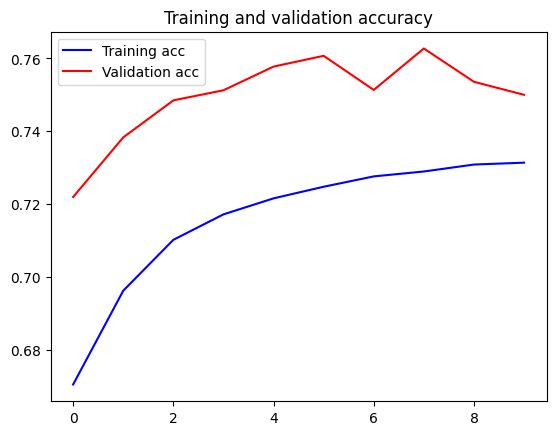

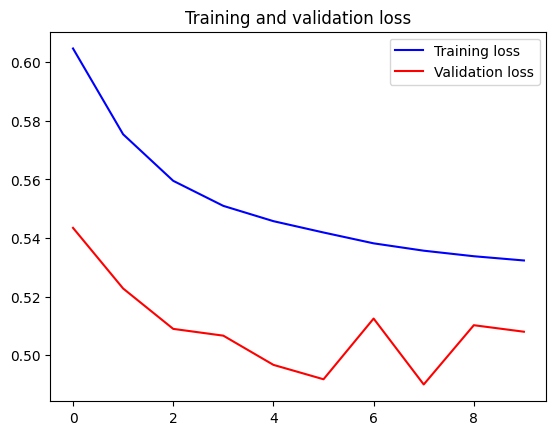

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
%%time
score = model_RNN.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 3s 7ms/step - loss: 0.5070 - acc: 0.7512

ACCURACY: 0.7512375116348267
LOSS: 0.5070255994796753
CPU times: user 2.56 s, sys: 109 ms, total: 2.67 s
Wall time: 2.83 s


32/32 [==============================] - 1s 23ms/step


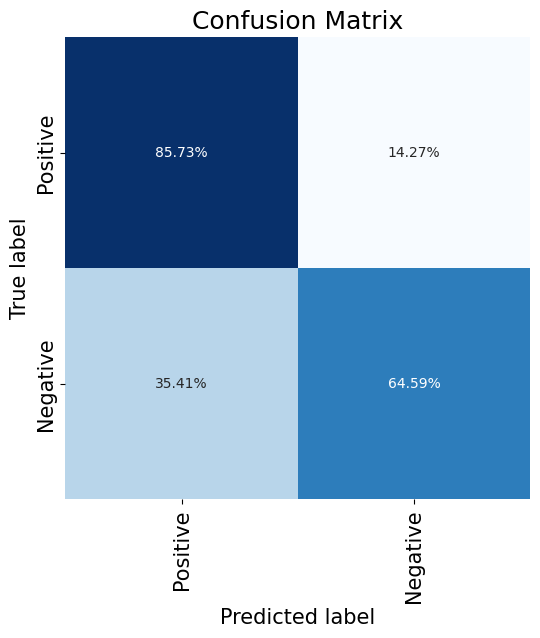

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
#Matrice de confusion
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model_RNN.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]
y_test_1d = list(test_data.sentiment)
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_1d, y_pred_1d)

# Calculate percentage values for each class
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix using seaborn with percentage values
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='Blues', cbar=False,
            xticklabels=train_data.sentiment.unique(), yticklabels=train_data.sentiment.unique())
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predicted label', fontsize=15)
plt.ylabel('True label', fontsize=15)
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.71      0.86      0.77    159494
    Positive       0.82      0.65      0.72    160506

    accuracy                           0.75    320000
   macro avg       0.76      0.75      0.75    320000
weighted avg       0.76      0.75      0.75    320000



In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_1d, y_pred_1d)

0.7512375

# LSTM Model

In [ ]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
model_lstm = Sequential()
model_lstm.add(embedding_layer)
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 300)           87120300  
                                                                 
 dropout_2 (Dropout)         (None, 30, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 87280801 (332.95 MB)
Trainable params: 160501 (626.96 KB)
Non-trainable params: 87120300 (332.34 MB)
_________________________________________________________________


In [ ]:
model_lstm.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
%%time
history = model_lstm.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/10
1125/1125 [==============================] - 74s 63ms/step - loss: 0.5287 - accuracy: 0.7328 - val_loss: 0.4751 - val_accuracy: 0.7714 - lr: 0.0010
Epoch 2/10
1125/1125 [==============================] - 75s 67ms/step - loss: 0.4917 - accuracy: 0.7599 - val_loss: 0.4622 - val_accuracy: 0.7802 - lr: 0.0010
Epoch 3/10
1125/1125 [==============================] - 67s 60ms/step - loss: 0.4813 - accuracy: 0.7667 - val_loss: 0.4586 - val_accuracy: 0.7819 - lr: 0.0010
Epoch 4/10
1125/1125 [==============================] - 77s 68ms/step - loss: 0.4753 - accuracy: 0.7707 - val_loss: 0.4527 - val_accuracy: 0.7864 - lr: 0.0010
Epoch 5/10
1125/1125 [==============================] - 67s 59ms/step - loss: 0.4718 - accuracy: 0.7730 - val_loss: 0.4492 - val_accuracy: 0.7883 - lr: 0.0010
Epoch 6/10
1125/1125 [==============================] - 69s 62ms/step - loss: 0.4686 - accuracy: 0.7749 - val_loss: 0.4470 - val_accuracy: 0.7895 - lr: 0.0010
Epoch 7/10
1125/1125 [========================

In [ ]:
model_lstm.save('./lstm_model.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Evaluation LSTM

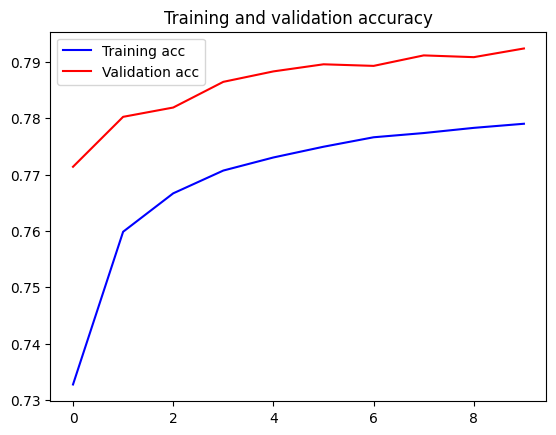

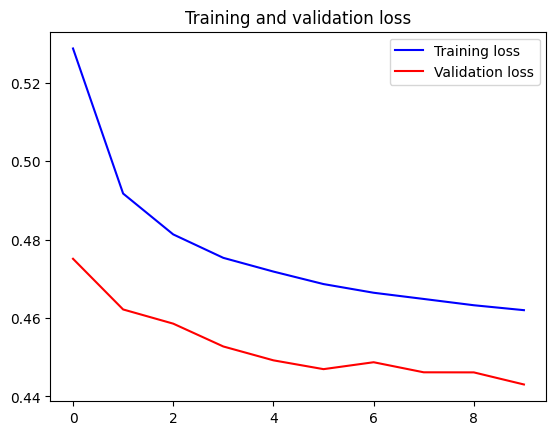

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
%%time
score = model_lstm.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 6s 17ms/step - loss: 0.4396 - accuracy: 0.7937

ACCURACY: 0.7936593890190125
LOSS: 0.43958988785743713
CPU times: user 5.59 s, sys: 146 ms, total: 5.74 s
Wall time: 10.8 s


32/32 [==============================] - 3s 69ms/step


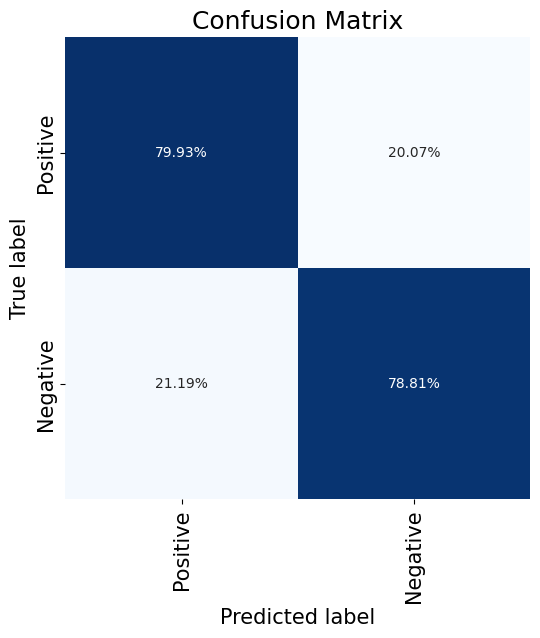

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
#Matrice de confusion
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model_lstm.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]
y_test_1d = list(test_data.sentiment)
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_1d, y_pred_1d)

# Calculate percentage values for each class
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix using seaborn with percentage values
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='Blues', cbar=False,
            xticklabels=train_data.sentiment.unique(), yticklabels=train_data.sentiment.unique())
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predicted label', fontsize=15)
plt.ylabel('True label', fontsize=15)
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.79      0.80      0.79    159494
    Positive       0.80      0.79      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_1d, y_pred_1d)

0.793659375

# LSTM prediction test

In [ ]:
import time
def predict_LSTM(text):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_SEQUENCE_LENGTH)
    # Predict
    score = model_lstm.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [ ]:
import time
def predict_RNN(text):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_SEQUENCE_LENGTH)
    # Predict
    score = model_RNN.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [ ]:
predict_RNN("I love your outfit")

1/1 [==============================] - 0s 197ms/step


<ipython-input-52-6c0cd08c2a54>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label": label, "score": float(score),


{'label': 'Positive',
 'score': 0.9398746490478516,
 'elapsed_time': 0.24885940551757812}

In [ ]:
predict_LSTM("I love your outfit")

1/1 [==============================] - 0s 363ms/step


<ipython-input-51-80c02eb69708>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label": label, "score": float(score),


{'label': 'Positive',
 'score': 0.976171612739563,
 'elapsed_time': 0.43327784538269043}

In [ ]:
predict_LSTM("I don't know where to go")

1/1 [==============================] - 0s 46ms/step


<ipython-input-51-80c02eb69708>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label": label, "score": float(score),


{'label': 'Negative',
 'score': 0.3054068684577942,
 'elapsed_time': 0.136322021484375}

In [ ]:
predict_RNN("I don't know where to go")

1/1 [==============================] - 0s 23ms/step


<ipython-input-52-6c0cd08c2a54>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label": label, "score": float(score),


{'label': 'Negative',
 'score': 0.294198602437973,
 'elapsed_time': 0.07741475105285645}

In [ ]:
predict_RNN("BDM is awesome")

1/1 [==============================] - 0s 61ms/step


<ipython-input-52-6c0cd08c2a54>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label": label, "score": float(score),


{'label': 'Positive',
 'score': 0.9350160956382751,
 'elapsed_time': 0.23141956329345703}

In [ ]:
predict_LSTM("BDM is awesome")

1/1 [==============================] - 0s 25ms/step


<ipython-input-51-80c02eb69708>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label": label, "score": float(score),


{'label': 'Positive',
 'score': 0.9858555197715759,
 'elapsed_time': 0.07009196281433105}

In [ ]:
predict_RNN("my model is overfitting, it's making me mad")

1/1 [==============================] - 0s 35ms/step


<ipython-input-52-6c0cd08c2a54>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label": label, "score": float(score),


{'label': 'Negative',
 'score': 0.2839009761810303,
 'elapsed_time': 0.10167050361633301}

In [ ]:
predict_LSTM("my model is overfitting, it's making me mad")

1/1 [==============================] - 0s 41ms/step


<ipython-input-51-80c02eb69708>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label": label, "score": float(score),


{'label': 'Negative',
 'score': 0.24988846480846405,
 'elapsed_time': 0.09912443161010742}